In [1]:
import pandas as pd
import numpy as np

Merge the price data the same way as the quote and ask data, while for the size variable we sum over each 10 second period.

In [2]:
df_t=pd.read_csv('vwap_test.csv',header=0)


In [3]:
df_t.head(5)

,DATE,TIME_M,EX,SYM_ROOT,SYM_SUFFIX,TR_SCOND,SIZE,PRICE,TR_CORR,TR_SEQNUM,TR_SOURCE,TR_RF
0,20181101,9:30:00.044174000,P,TJX,NaN,I,50,110.00,0,777101,C,NaN
1,20181101,9:30:00.044206000,P,TJX,NaN,Q,50,110.00,0,777201,C,NaN
2,20181101,9:30:00.707325000,N,TJX,NaN,O,27979,109.77,0,789001,C,NaN
3,20181101,9:30:00.716759000,N,TJX,NaN,F I,15,110.00,0,791001,C,NaN
4,20181101,9:30:00.721658000,X,TJX,NaN,I,95,110.13,0,791301,C,NaN


In [38]:
D=list(set(df_t['DATE']))

In [47]:

St=[]
for d in D[:-1]:
    s=[]
    i=-1
    T=[]
    df_d=df_t[df_t['DATE']==d]
    for j in range(len(df_d['TIME_M'])):
        if np.array(df_d['TIME_M'])[j][:-13] not in T:
            i+=1
            T.append(np.array(df_d['TIME_M'])[j][:-13])
           
            s.append(np.array(df_d['SIZE'])[j])
        else:
            s[i]+=np.array(df_d['SIZE'])[j]
    St.append(s)
    #print(T)

In [48]:
St=np.array(St,dtype=float)

In [ ]:
for i in range(len(St)):
    St[i,:]=St[i,:]/float(np.sum(St[i,:]))

In [50]:
vol_mean=np.mean(St,axis=0)
vol_mean

array([0.14793926, 0.03033584, 0.04571237, 0.03617353, 0.03287485,
       0.07207016, 0.04908654, 0.0357939 , 0.02786809, 0.03060721,
       0.03227252, 0.02233412, 0.03497654, 0.02646295, 0.02044929,
       0.02639767, 0.03035865, 0.01913201, 0.02550396, 0.02082733,
       0.02172022, 0.02981854, 0.02266234, 0.02008545, 0.0236389 ,
       0.0202179 , 0.02364464, 0.02388937, 0.02253231, 0.02461357])

In [56]:
df_d=df_t[df_t['DATE']==D[-1]]
T=[]
s=[]
p=[]
i=-1
for j in range(len(df_d['TIME_M'])):
    if np.array(df_d['TIME_M'])[j][:-13] not in T:
        i+=1
        T.append(np.array(df_d['TIME_M'])[j][:-13])
        p.append(np.array(df_d['PRICE'])[j])
        s.append(np.array(df_d['SIZE'])[j])
    else:
        s[i]+=np.array(df_d['SIZE'])[j]

In [53]:
s_per=np.array(s)/float(sum(s))

In [71]:
def execution(target_percentage,size,real_volume,real_price):
    i=0
    VWAP=0
    size_=size
    history=[]
    while size>0:
        goal=target_percentage[i]*size_
        if i==len(target_percentage)-1:
            realized=min(size,real_volume[i])
        else:
            realized=min(goal,real_volume[i])
        realized=min(realized,size)
        VWAP+=realized*real_price[i]
        history.append(realized)
        
        i+=1
        size-=realized
    history=np.array(history)
    return history,size,VWAP/float(np.sum(history))
def benchmark(size,real_volume,real_price):
    history=np.array(real_volume)*size/float(sum(real_volume))
    VWAP=np.sum(history*np.array(real_price))
    return history,VWAP/float(np.sum(history))
execution(vol_mean,100000,s,p)       

(array([10264.        ,  3033.58354019,  4571.23656897,  2159.        ,
         3287.48458488,  7207.01585709,  4908.65375195,  3579.38999754,
         2786.80869391,  3060.72115135,  3227.25153241,  2233.41180093,
         3497.65375672,  2646.29480411,  2044.92854923,  2639.76688366,
         3035.8646847 ,  1913.2010304 ,  2550.39584422,  2082.73320928,
         2172.0215134 ,  2981.85378659,  2266.23401006,  2008.54470571,
         2363.89038321,  2021.79032983,  2364.46429082,  2388.93748382,
         2253.23056367,  8449.63669135]), 0.0, 51.94520919251382)

In [68]:
benchmark(100000,s,p)

(array([ 1503.62942508,  1602.36736667,   922.04243974,   316.28370311,
        27302.35930942,  5031.67964372,  3425.21040411,  3423.01297217,
         3679.67302213,  2292.21449866,  3184.07887316,  1721.02869114,
         1213.86140064,  3507.68734938,   761.62990851,  1057.11125598,
         2341.72996491,  1413.82770669, 11348.41748277,  2777.26097434,
         1758.82452041,  4701.91835808,  1073.37225229,  1269.09018993,
         2270.09368385,  1764.24485252,  2660.79708181,  2334.55168726,
         1812.58835508,  1529.41262644]), 51.95759727943276)

Forward filling to retain a complete series of length 180.

In [7]:
pt=Pt[4:-4]
st=St[4:-4]
tt=T2[4:-4]


In [8]:
pt=np.array(pt)
st=np.array(st)

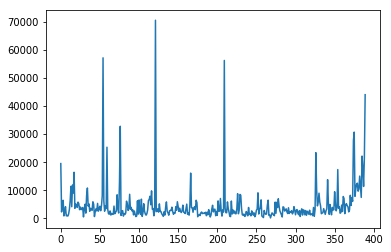

In [9]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.plot(st)

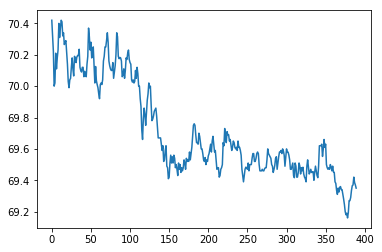

In [10]:
plt.plot(pt)

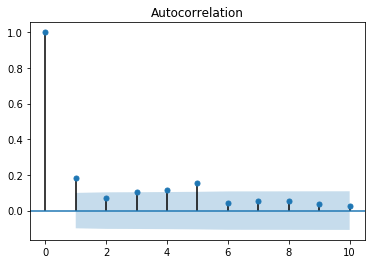

In [11]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(st,lags=10)
plt.show()

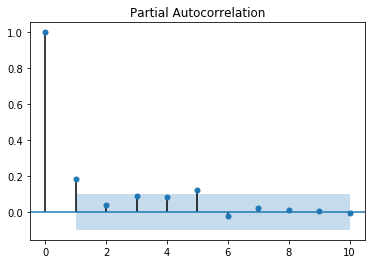

In [12]:
plot_pacf(st,lags=10)
plt.show()

In [47]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(st, order=(5,1,1),exog=pt)

In [48]:
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  389
Model:                 ARIMA(5, 1, 1)   Log Likelihood               -3973.958
Method:                       css-mle   S.D. of innovations           6597.258
Date:                Sat, 20 Apr 2019   AIC                           7965.917
Time:                        12:37:10   BIC                           8001.589
Sample:                             1   HQIC                          7980.059
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       9400.5411   6296.745      1.493      0.136   -2940.853    2.17e+04
x1          -134.5768     90.297     -1.490      0.137    -311.557      42.403
ar.L1.D.y      0.1201      0.059      2.050      0.0

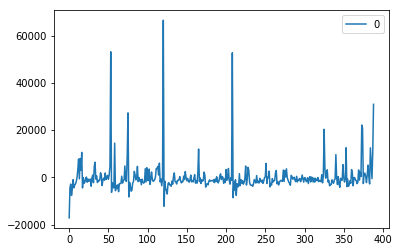

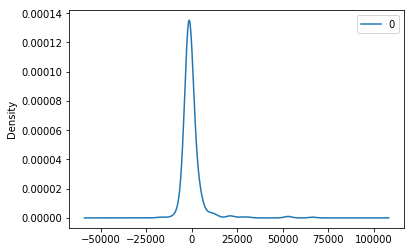

                  0
count    389.000000
mean     -63.365357
std     6634.858175
min   -17178.102149
25%    -2349.260651
50%    -1259.316443
75%      162.149841
max    66456.328067


In [49]:
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

Text(0.5,1,'12.14 Stock A Volume Prediction Based on ARMA(5,1,1)')

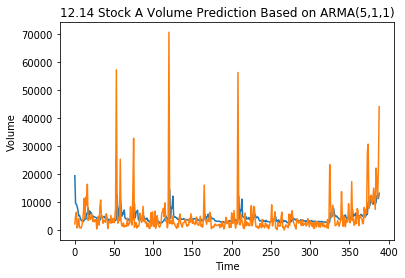

In [50]:

pred=st+model_fit.predict(1,len(st),exog=pt,dynamic=False)
pred_n=pred/sum(pred)
v_n=st/sum(st)
plt.plot(pred[:-1])
plt.plot(st[1:])
plt.xlabel('Time')
plt.ylabel('Volume')
plt.title('12.14 Stock A Volume Prediction Based on ARMA(5,1,1)')